# Système de recommandation

Êtes-vous maintenant prêt à recommander des images à un utilisateur ? Dans cette tâche, votre objectif est de construire le système de recommandation. Quelle approche avez-vous décidé de prendre ? Filtrage collaboratif, basé sur le contenu ou une approche hybride ? Pour chaque utilisateur, êtes-vous maintenant en mesure de construire une profil ? Quel type d'information avez-vous utilisé pour établir un profil d'utilisateur profil ? Qu'est-ce qui manque ? Quelles sont les limites de votre proposition ?


#### Réponses
Nous avons les prérequis nécessaires au système de recommandation, notamment un système d'utilisateurs avec leurs préférences, un système de tagging d'images, de propriétés d'images, et leur analyse statistique. Nous avons décidé de nous baser sur un système de double filtrage pour la recommandation en se basant sur une participation de l'utilisateur qui doit indiquer sur un ensemble d'images ce qu'il aime ou non. Il aura la possibilité de continuer autant qu'il le souhaite (et dans la limite des images disponibles) afin d'améliorer toujours plus la précision.

Le double filtrage fera usage d'un système de clustering pour prédire les images recommandées pour l'utilisateur en fonction de ses interactions. Ensuite, nous soumettrons cette sélection d'image à un algorithme de classification afin de déterminer si parmi ces dernières, une image serait détectée comme potentiellement inadaptée aux goûts de l'utilisateur.

## Préparation des données

Nous devons d'abord générer un fichier qui regroupe l'ensemble des données récupérées précédemment dans un format utilisable. Nous commencerons par convertir les codes hexadécimaux en couleurs les plus proches possibles, une trop grande variété de nuance sur un si petit échantillon (100 images) empêcherait d'être pertinent, nous baser sur les noms de couleurs en CSS3 pourrait donc être utile.

In [ ]:
!pip install scipy
!pip install webcolors

Closest match: greenyellow


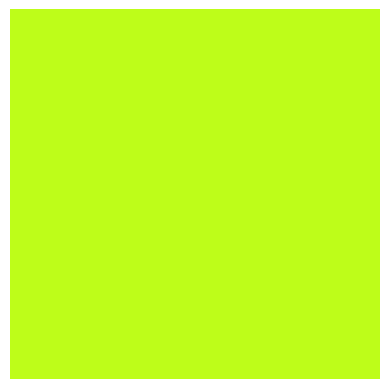

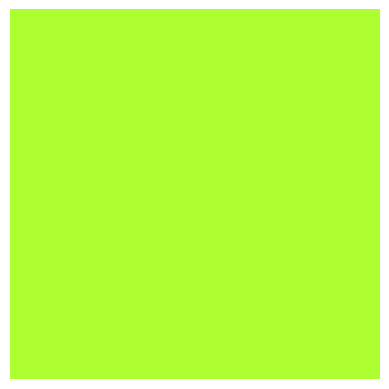

In [16]:
from scipy.spatial import KDTree
from webcolors import (
    CSS3_NAMES_TO_HEX,
    hex_to_rgb,
)

def convert_rgb_to_names(rgb_tuple):
    # a dictionary of all the hex and their respective names in css3
    css3_db = CSS3_NAMES_TO_HEX
    names = []
    rgb_values = []
    for color_name, color_hex in css3_db.items():
        names.append(color_name)
        rgb_values.append(hex_to_rgb(color_hex))
    
    kdt_db = KDTree(rgb_values)
    distance, index = kdt_db.query(rgb_tuple)
    return (names[index], rgb_values[index])

# Testing
test_color = (190,253,25)
result = convert_rgb_to_names(test_color)
print(f'Closest match: {result[0]}')

# Display original color and closest match
import matplotlib.pyplot as plt
import numpy as np

def plot_color(rgb_tuple):
    plt.imshow([[np.array(rgb_tuple)/255]])
    plt.axis('off')
    plt.show()
        
plot_color(test_color)
plot_color(result[1])

Nous devons à présent générer un jeu de données qui représentera les images sous la forme d'un tableau à deux dimensions avec les colonnes "couleurs" et "tags" qui seront eux mêmes des tableaux limités à cinq éléments chacun, qui seront rempli par "None" en cas de valeurs manquantes.

Exemple :
[["green", "red", "blue", "greenyellow", "None"], ["nature", "sky", "people, "park", "river"], "thumbnail", "landscape"]

In [21]:
import json

def categorize_image_size(width, height):
    """
    Catégorise la taille de l'image en petite, moyenne ou grande.
    
    :param width: Largeur de l'image.
    :param height: Hauteur de l'image.
    :return: Catégorie de taille.
    """
    pixels = width * height
    if pixels < 640 * 480:
        return 'small'
    elif pixels <= 1280 * 1024:
        return 'medium'
    else:
        return 'large'

def convert_color_array_to_name(colorarray):
    """
    Convertit un tableau de couleurs hexadécimales en noms de couleurs CSS3.
    
    :param colorarray: Tableau de couleurs hexadécimales.
    :return: Tableau de noms de couleurs CSS3.
    """
    color_names = []
    for color in colorarray:
        colorrgb = hex_to_rgb(color)
        result = convert_rgb_to_names(colorrgb)
        color_names.append(result[0])
    return color_names

def cut_array(arr):
    """
    Coupe un tableau pour qu'il ait une longueur de 5.
    Si la longueur du tableau est inférieure à 5, ajoute des éléments 'None'.
    
    :param arr: Tableau à couper.
    :return: Tableau de longueur 5.
    """
    if len(arr) > 5:
        return arr[:5]
    else:
        arr += ['None'] * (5 - len(arr))
        return arr
    
def process_tagsarray(usertags, autotags):
    """
    Traite les tableaux de tags utilisateur et automatiques.
    Si le nombre de tags utilisateur est inférieur à 5, ajoute des tags automatiques.
    
    :param usertags: Tableau de tags utilisateur.
    :param autotags: Tableau de tags automatiques.
    :return: Tableau de tags.
    """
    tags_array = []
    for tags in usertags:
        tags_array.append(tags)
        
    if(len(tags_array) < 5):
        for tags in autotags:
            tags_array.append(tags)
                
    return tags_array



dataarray = []

with open('annotations.json') as f:
    annotations = json.load(f)
    
    for obj in annotations:
        data = []
             
        dominantcolors_array = convert_color_array_to_name(obj['Dominant Colors'])
        dominantcolors_array = cut_array(dominantcolors_array)
        data.append(dominantcolors_array)
        
        tags_array = process_tagsarray(obj['User Tags'], obj['Auto Tags'])
        tags_array = cut_array(tags_array)
        data.append(tags_array)
        
        width, height = map(int, obj['Image Size'].split('x'))
        data.append(categorize_image_size(width, height))
        data.append(obj['Orientation'])
        
        imgdata = {
            "filename" : obj['Filename'],
            "data" : data
        }
        
        dataarray.append(imgdata)
        
# save as new json under name "images_dataset"
with open('images_dataset.json', 'w') as f:
    json.dump(dataarray, f, indent=4)


# Display the first 5 elements of the new json file
with open('images_dataset.json') as f:
    data = json.load(f)
    for i in range(5):
        print(data[i])
        print()

{'filename': 'Curitiba Eixos e densidade 78 (24160257688).jpg', 'data': [['black', 'grey', 'lightgray', 'darkolivegreen', 'dimgrey'], ['ville', 'ciel', 'maisons', 'immeubles', 'arbres'], 'medium', 'landscape']}

{'filename': 'Pokhara1.JPG', 'data': [['darkslategray', 'lightslategrey', 'lightsteelblue', 'gainsboro', 'grey'], ['ville', 'ciel', 'maisons', 'immeubles', 'arbres'], 'large', 'landscape']}

{'filename': 'Indian-Nepalese border gate at Birgunj.jpg', 'data': [['darkslategray', 'lightsteelblue', 'black', 'dimgrey', 'skyblue'], ['temple', 'asie', 'arbres', 'Indian-Nepalese border gate at Birgunj', 'None'], 'medium', 'landscape']}

{'filename': 'Thimphu-12-vom Buddha Dordenma-2015-gje.jpg', 'data': [['darkolivegreen', 'black', 'darkgrey', 'darkslategray', 'grey'], ['ville', 'maisons', 'immeubles', 'arbres', 'Views of Thimphu city'], 'large', 'landscape']}

{'filename': 'Montage-of-Makhachkala-(2016).png', 'data': [['darkgrey', 'dimgrey', 'gainsboro', 'dodgerblue', 'black'], ['templ

## Recommandation des images en fonction des interactions

Nous utiliserons ici un algorithme de clustering que nous entraînerons sur l'ensemble des images récupérées, il nous permettra de déterminer les images qui pourraient plaire à un utilisateur en fonction d'une image avec laquelle il aurait intéragit positivement en fonction des similitudes.

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import json

# Sample data
data = []

with open('images_dataset.json') as f:
    raw_dataset = json.load(f)
    
    for entry in raw_dataset:
        data.append(entry['data'])

# Encode categorical features and labels
colorlabel_encoders = [LabelEncoder() for _ in range(len(data[0][0]))]
categorylabel_encoders = [LabelEncoder() for _ in range(len(data[0][1]))]
label_encoders = [LabelEncoder() for _ in range(len(data[0]) - 2)]

encoded_data = []
for i, column in enumerate(zip(*data)):
    if(i < 2):
        if(i == 0):
            encoded_colors = []
            for y, color in enumerate(zip(*column)):
                encoded_data.append(colorlabel_encoders[y].fit_transform(color))
        else:
            encoded_tags = []
            for y, tag in enumerate(zip(*column)):
                encoded_data.append(categorylabel_encoders[y].fit_transform(tag))
    else:
        encoded_data.append(label_encoders[i-2].fit_transform(column))

X = list(zip(*encoded_data))  # Features

# Clustering
k = 2  # Number of clusters
kmeans = KMeans(n_clusters=k, n_init=10)
kmeans.fit(X)
clusters = kmeans.labels_

# Add cluster labels to the original data
data_with_clusters = pd.DataFrame(data, columns=["Color", "Category", "Size", "Type"])
data_with_clusters["Cluster"] = clusters

# Recommendation function
def recommend_items(cluster, data_with_clusters):
    """
    Recommends items from a specific cluster.
    
    :param cluster: Cluster number.
    :param data_with_clusters: Data with cluster labels.
    :return: Recommended items.
    """
    items_in_cluster = data_with_clusters[data_with_clusters["Cluster"] == cluster]
    recommended_items = items_in_cluster.sample(n=3)  # Sample 3 items from the cluster
    return recommended_items

# Returns a list of recommended items based on a sample item
def get_recommandations(sample_item, data_with_clusters, kmeans, label_encoders, colorlabel_encoders, categorylabel_encoders):
    """
    Returns a list of recommended items based on a sample item.
    
    :param sample_item: Sample item attributes.
    :param data_with_clusters: Data with cluster labels.
    :param kmeans: KMeans model.
    :param label_encoders: Label encoders for categorical features.
    :param colorlabel_encoders: Label encoders for color features.
    :param categorylabel_encoders: Label encoders for category features.
    :return: List of recommended items.
    """
    encoded_interaction = []
    for i, column in enumerate(sample_item):
        if(i < 2):
            if(i == 0):
                for y, color in enumerate(column):
                    encoded_interaction.append(colorlabel_encoders[y].transform([color])[0])
            else:
                for y, tag in enumerate(column):
                    encoded_interaction.append(categorylabel_encoders[y].transform([tag])[0])
        else:
            encoded_interaction.append(label_encoders[i-2].transform([column])[0])

    cluster = kmeans.predict([encoded_interaction])[0]
    recommendations = recommend_items(cluster, data_with_clusters)


    reco_list = recommendations.values.tolist()
    reco_list = [sublist[:-1] for sublist in reco_list]
    
    return reco_list
    
# Example usage
sample_item = [['darkslategray', 'lightsteelblue', 'black', 'dimgrey', 'skyblue'], ['temple', 'asie', 'arbres', 'Indian-Nepalese border gate at Birgunj', 'None'], 'medium', 'landscape']  # Sample item attributes

recommendations = get_recommandations(sample_item, data_with_clusters, kmeans, label_encoders, colorlabel_encoders, categorylabel_encoders)
print("Recommended items:")
print(recommendations)


Recommended items:
[[['darkolivegreen', 'black', 'darkgrey', 'darkslategray', 'grey'], ['ville', 'maisons', 'immeubles', 'arbres', 'Views of Thimphu city'], 'large', 'landscape'], [['whitesmoke', 'grey', 'lightsteelblue', 'darkslategray', 'steelblue'], ['temple', 'monuments', 'ciel', 'mer', 'immeuble'], 'large', 'portrait'], [['wheat', 'darkolivegreen', 'darkslategray', 'snow', 'rosybrown'], ['foule', 'arbres', 'immeubles', 'Bibi-Khanum Mosque - General view', 'Markets in Samarkand'], 'small', 'landscape']]


Nous pouvons à présent tester la recommandation pour un utilisateur avec ce seul algorithme :

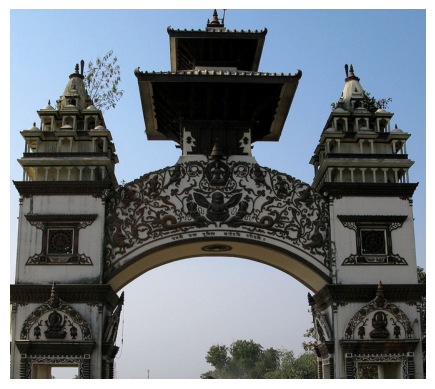

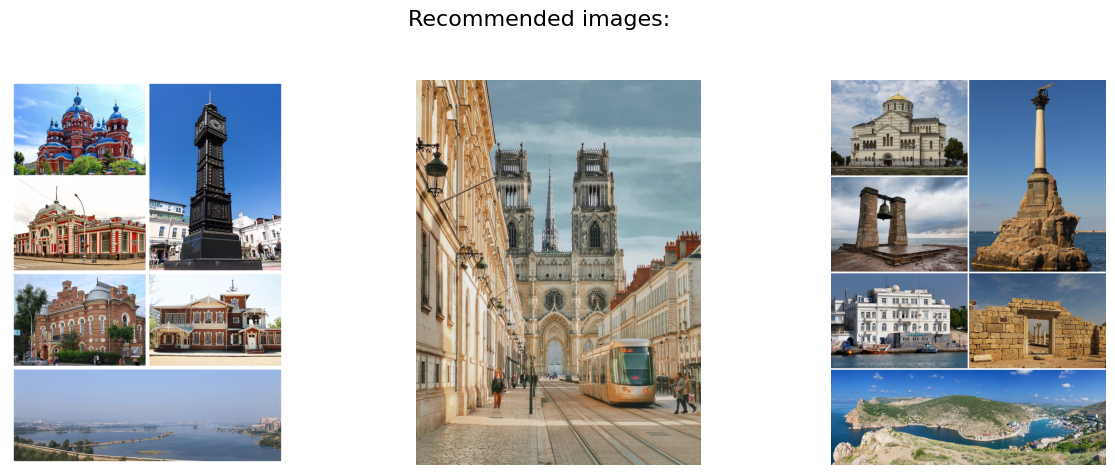

In [12]:
import os
import matplotlib.pyplot as plt
import IPython.display as ipd
import json

def display_image(filename):
    """
    Displays an image from the /images folder based on the filename.
    
    :param filename: Image filename.
    """
        # Clear the output
    ipd.clear_output(wait=True)

    # Display the image
    img = plt.imread(f'images/{filename}')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
def display_recommandations(recommendations):
    """
    Displays a list of recommended images.
    
    :param recommendations: List of recommended images.
    """
    num_images = len(recommendations)

    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle('Recommended images:', fontsize=16, y=1.02)

    # Display each image
    for i, filename in enumerate(recommendations):
        image_path = os.path.join('images', filename)
        img = plt.imread(image_path)

        axs[i].imshow(img)
        axs[i].axis('off')

    plt.show()


selected_img = ''
imgdata = None
raw_dataset = []

with open('images_dataset.json') as f:
    raw_dataset = json.load(f)
    
    for entry in raw_dataset:
        selected_img = entry['filename']
        display_image(selected_img)
        
        answer = input("Do you like this picture ? (y/n)")
        if answer == 'y' or answer == 'yes':
            imgdata = entry['data']
            break
        
if imgdata:
    recommendations = get_recommandations(imgdata, data_with_clusters, kmeans, label_encoders, colorlabel_encoders, categorylabel_encoders)

    # Find and display the recommended images from dataset
    recommandations_filepaths = []
    
    for reco in recommendations:
        for entry in raw_dataset:
            if entry['data'] == reco:
                recommandations_filepaths.append(entry['filename'])
                break
            
    display_recommandations(recommandations_filepaths)

On remarque que l'algorithme reste plutôt pertinent, bien que cela soit perfectible. Les tags utilisateurs influencent beaucoup la précision de la recommandation, ainsi plus les tags seront pertinents et plus l'algorithme proposera de bons groupes d'images.

### Algorithme de classification

Nous allons à présent affiner ces résultats en permettant à l'utilisateur de réellement préciser ses goûts à travers un système qui rappellera celui des applications de rencontres bien connues, le système de "swipe", où l'on aime une image en appuyant à gauche et on aime pas une image en appuyant à droite. L'utilisateur devra au minimum faire cela pour 10 images afin d'améliorer la précision. Il pourra ensuite continuer autant qu'il le souhaite, ou arrêter directement.

In [ ]:
!pip install pynput==1.7.6

Press 'left' if you like the picture, 'right' if you don't, or 'esc' to exit (you can now stop at any moment)


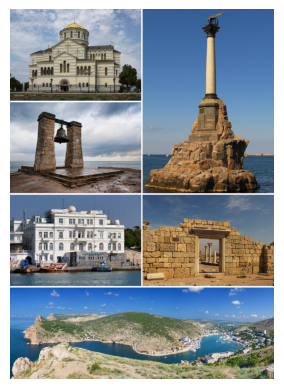

Escape key pressed, ending program
[[['black', 'grey', 'lightgray', 'darkolivegreen', 'dimgrey'], ['ville', 'ciel', 'maisons', 'immeubles', 'arbres'], 'medium', 'landscape'], [['darkslategray', 'lightslategrey', 'lightsteelblue', 'gainsboro', 'grey'], ['ville', 'ciel', 'maisons', 'immeubles', 'arbres'], 'large', 'landscape'], [['darkslategray', 'lightsteelblue', 'black', 'dimgrey', 'skyblue'], ['temple', 'asie', 'arbres', 'Indian-Nepalese border gate at Birgunj', 'None'], 'medium', 'landscape'], [['darkolivegreen', 'black', 'darkgrey', 'darkslategray', 'grey'], ['ville', 'maisons', 'immeubles', 'arbres', 'Views of Thimphu city'], 'large', 'landscape'], [['darkgrey', 'dimgrey', 'gainsboro', 'dodgerblue', 'black'], ['temples', 'religion', 'ville', 'ciel', 'Makhachkala'], 'large', 'portrait'], [['lightgray', 'darkslategray', 'darkslategray', 'dimgrey', 'darkgrey'], ['monument', 'ciel', 'eau', 'pont', 'Clyde Auditorium'], 'medium', 'landscape'], [['darkgrey', 'darkslategray', 'lightslategr

In [19]:
from pynput import keyboard

data = []
y_labels = []
exited = False

def on_press(key):
    global y_labels, exited
    try:
        if key == keyboard.Key.esc:
            if(len(y_labels) >= 10):
                print('Escape key pressed, ending program')
                exited = True
                return False  # Stop listener
        elif key == keyboard.Key.left:
            print('You liked this picture')
            y_labels.append("Liked")
            return False  # Stop listener
        elif key == keyboard.Key.right:
            print('You did not like this picture')
            y_labels.append("NotLiked")
            return False  # Stop listener
    except AttributeError:
        pass

def display_image_alt(filename):
    """
    Displays an image from the /images folder based on the filename.
    
    :param filename: Image filename.
    """
    # Clear the output
    ipd.clear_output(wait=True)

    # Display the image
    if(len(data) < 10):
        print(f"Press 'left' if you like the picture, 'right' if you don't (you need to continue for {10 - len(data)} more images)")
    else:
        print("Press 'left' if you like the picture, 'right' if you don't, or 'esc' to exit (you can now stop at any moment)")
    img = plt.imread(f'images/{filename}')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    
# Starting to create the dataset
with open('images_dataset.json') as f:
    raw_dataset = json.load(f)

    for entry in raw_dataset:
        current_entry = entry
        selected_img = entry['filename']
        
        display_image_alt(selected_img)
        data.append(entry['data'])

        # Start the keyboard listener
        with keyboard.Listener(on_press=on_press) as listener:
            listener.join()

        if exited == True and len(y_labels) < len(data):
            # remove last entry from data if user stopped the program
            data.pop()
            break
        
    print(data)
    print(y_labels)

Une fois le jeu de données récolté, nous pouvons à présent entraîner notre modèle dessus. Nous utiliserons SVC, une implémentation de la méthode des machines à vecteurs de support (SVM), qui est une technique de classification basée sur la recherche d'un hyperplan séparant les données de différentes classes.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Encode categorical features and labels
colorlabel_encoders = [LabelEncoder() for _ in range(len(data[0][0]))]
categorylabel_encoders = [LabelEncoder() for _ in range(len(data[0][1]))]
label_encoders = [LabelEncoder() for _ in range(len(data[0]) - 2)]

encoded_data = []
for i, column in enumerate(zip(*data)):
    if(i < 2):
        if(i == 0):
            encoded_colors = []
            for y, color in enumerate(zip(*column)):
                encoded_data.append(colorlabel_encoders[y].fit_transform(color))
        else:
            encoded_tags = []
            for y, tag in enumerate(zip(*column)):
                encoded_data.append(categorylabel_encoders[y].fit_transform(tag))
    else:
        encoded_data.append(label_encoders[i-2].fit_transform(column))

X = list(zip(*encoded_data))  # Features
y = y_labels  # Labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Train the logistic regression classifier
classifier = svm.SVC()
classifier.fit(X_train, y_train)

# Predictions
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6


### Système final

Nous pouvons à présent faire intéragir l'utilisateur avec des images et combiner nos deux algorithmes pour faire une recommandation pertinente :

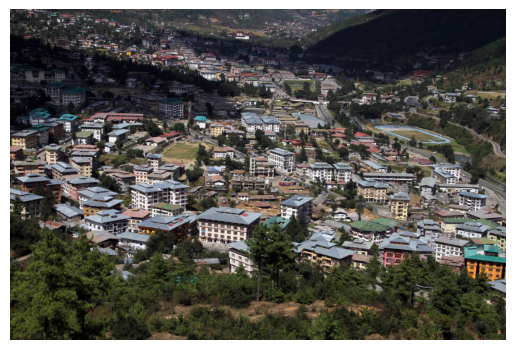

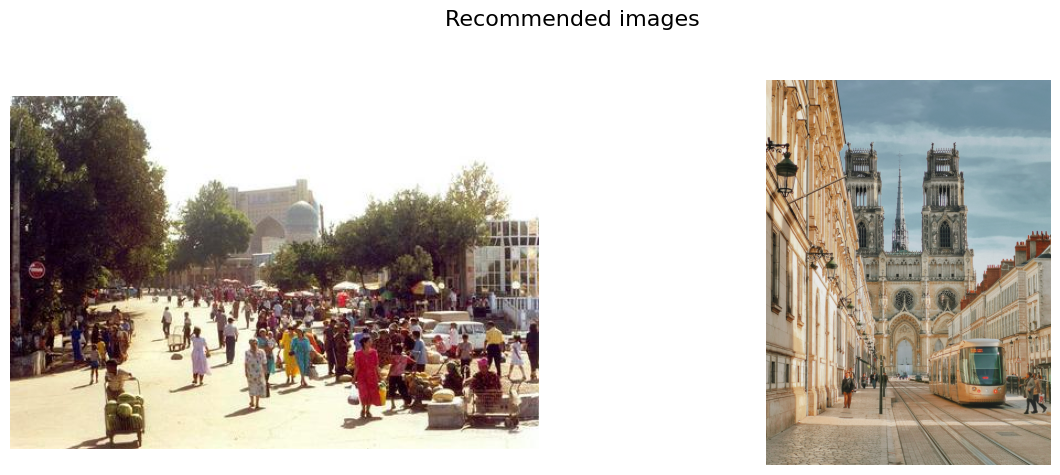

In [52]:
selected_img = ''
imgdata = None
raw_dataset = []

def display_image(filename):
    """
    Displays an image from the /images folder based on the filename.
    
    :param filename: Image filename.
    """
        # Clear the output
    ipd.clear_output(wait=True)

    # Display the image
    img = plt.imread(f'images/{filename}')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def refine_recommandations(reco_list):
    """
    Refines the list of recommendations based on the classifier predictions.
    
    :param reco_list: List of recommendations.
    :return: Refined list of recommendations.
    """
    global label_encoders, colorlabel_encoders, categorylabel_encoders, classifier
    refined_list = []
    
    for prediction in reco_list:
        encoded_array = []
        for i, column in enumerate(prediction):
            if(i < 2):
                if(i == 0):
                    for y, color in enumerate(column):
                        encoded_array.append(colorlabel_encoders[y].transform([color])[0])
                else:
                    for y, tag in enumerate(column):
                        encoded_array.append(categorylabel_encoders[y].transform([tag])[0])
            else:
                encoded_array.append(label_encoders[i-2].transform([column])[0])

        prediction_res = classifier.predict([encoded_array])[0]
        
        if prediction_res == 'Liked':
            refined_list.append(prediction)
    
    return refined_list

def display_recommandations(recommendations):
    """
    Displays a list of recommended images.
    
    :param recommendations: List of recommended images.
    """
    num_images = len(recommendations)

    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle('Recommended images', fontsize=16, y=1.02)

    # Display each image
    for i, filename in enumerate(recommendations):
        image_path = os.path.join('images', filename)
        img = plt.imread(image_path)

        if num_images == 1:  # If there's only one image, use axs instead of axs[i]
            axs.imshow(img)
            axs.axis('off')
        else:
            axs[i].imshow(img)
            axs[i].axis('off')

    plt.show()

with open('images_dataset.json') as f:
    raw_dataset = json.load(f)
    
    for entry in raw_dataset:
        selected_img = entry['filename']
        display_image(selected_img)
        
        answer = input("Do you like this picture ? (y/n)")
        if answer == 'y' or answer == 'yes':
            imgdata = entry['data']
            break
        
if imgdata:
    recommendations = get_recommandations(imgdata, data_with_clusters, kmeans, label_encoders, colorlabel_encoders, categorylabel_encoders)
    refined_rec_list = refine_recommandations(recommendations)

    # Find and display the recommended images from dataset
    recommandations_filepaths = []
    
    # If refined recommendations are found, display them
    if(len(refined_rec_list) > 0):
        for reco in refined_rec_list:
            for entry in raw_dataset:
                if entry['data'] == reco:
                    if(entry['filename'] not in recommandations_filepaths and entry['filename'] != selected_img):
                        recommandations_filepaths.append(entry['filename'])
                        break
        
        # If not enough refined recommendations are found, display original recommendations
        if(len(recommandations_filepaths) == 0):
            print("No refined recommendations found, displaying original recommendations.")
            for reco in recommendations:
                for entry in raw_dataset:
                    if entry['data'] == reco:
                        if(entry['filename'] not in recommandations_filepaths and entry['filename'] != selected_img):
                            recommandations_filepaths.append(entry['filename'])
                            break
    # If no refined recommendations are found, display original recommendations
    else:
        print("No refined recommendations found, displaying original recommendations.")
        for reco in recommendations:
            for entry in raw_dataset:
                if entry['data'] == reco:
                     if(entry['filename'] not in recommandations_filepaths and entry['filename'] != selected_img):
                        recommandations_filepaths.append(entry['filename'])
                        break

    display_recommandations(recommandations_filepaths)